## Тема:
«Обнаружение мошеннических операций с кредитными картами»


## Актуальность темы:
Преступления, связанные с кредитными картами, - одна из наиболее важных и распространённых проблем в области защиты информации в финансовой сфере, с которой сталкиваются финансовые организации и их клиенты. Для предотвращения списаний средств клиентов мошенниками необходимо определять легитимность транзакций.


## Исходные данные:
Датасет «Credit Card Fraud Detection. Anonymized credit card transactions labeled as fraudulent or genuine» (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). В нём содержатся уже преобразованные алгоритмом PCA данные.


## Ход работы:
Сначала будет проведён EDA. Алгоритмы, которые будут использованы в дальнейшем:
 - k-NN;
 - Логистическая регрессия;
 - XGBoost классификатор.

Будет проанализировано качество работы алгоритмов на исходных данных и на сбалансированных данных, при этом будут рассмотрены 2 случая - с удалением и без удаления аномалий. Качество работы алгоритмов будет определено по стандартным метрикам классификации. Так же авторы набора данных предложили использовать метрику AUPRC для несбалансированных данных.

---

## Импорт библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('./creditcard.csv') # загрузка данных о транзакциях

---

## Разведочный анализ данных

In [5]:
data.shape # форма данных

(284807, 31)

In [6]:
data.head() # первые 5 транзакций

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
data.isna().sum().max() # проверка на недостающие данные

0

Недостающих данных нет.

In [8]:
data['Class'].value_counts(normalize=True) # подсчёт элементов разных классов

0    0.998273
1    0.001727
Name: Class, dtype: float64

Как видно, наблюдается сильная ассиметрия количества представителей разных классов. Мошеннических транзакций в датасете гораздо меньше.

In [9]:
# масштабируем признаки Amount и Time
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data.Amount.values.reshape(-1, 1))
data['Time'] = scaler.fit_transform(data.Time.values.reshape(-1, 1))
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


Признаки Time и Amount нужно отмасштабировать. Особенно это важно для алгоритма k-NN, так как в нем испльзуется метрика расстояния между объектами.

In [10]:
X, y = data.drop(['Class'], axis=1), data[['Class']] # отделяем признаки от отклика

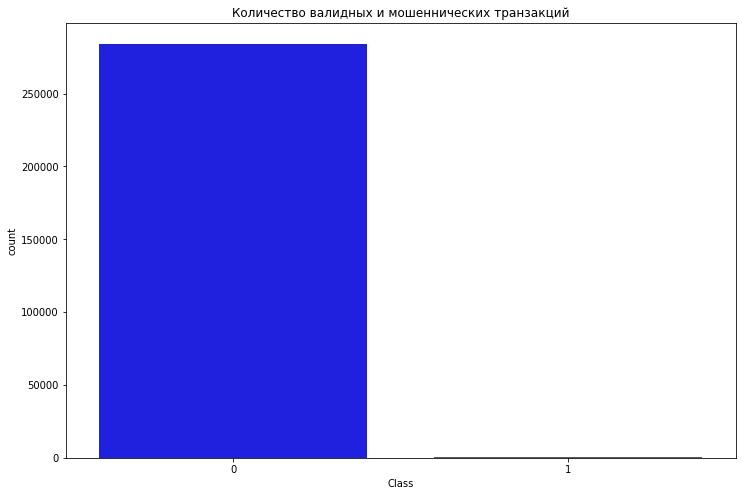

In [11]:
# столбчатая диаграмма количества объектов по классам в исходном наборе данных
plt.figure(figsize=(12, 8))
sns.countplot('Class', data=y, palette=['blue', 'red'])
plt.title('Количество валидных и мошеннических транзакций')
plt.show()

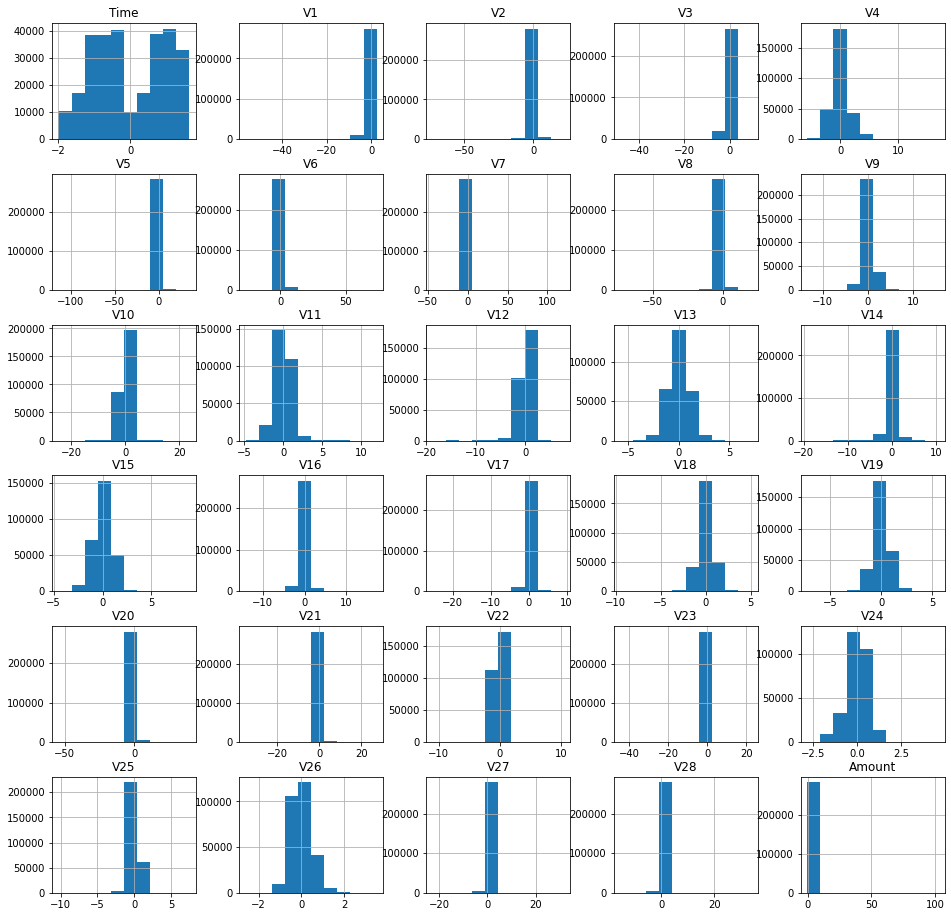

In [12]:
# графики гистограмм распределений всех признаков
fig = plt.figure(figsize=(16, 16))
ax = fig.gca()
X.hist(ax=ax)
plt.show()

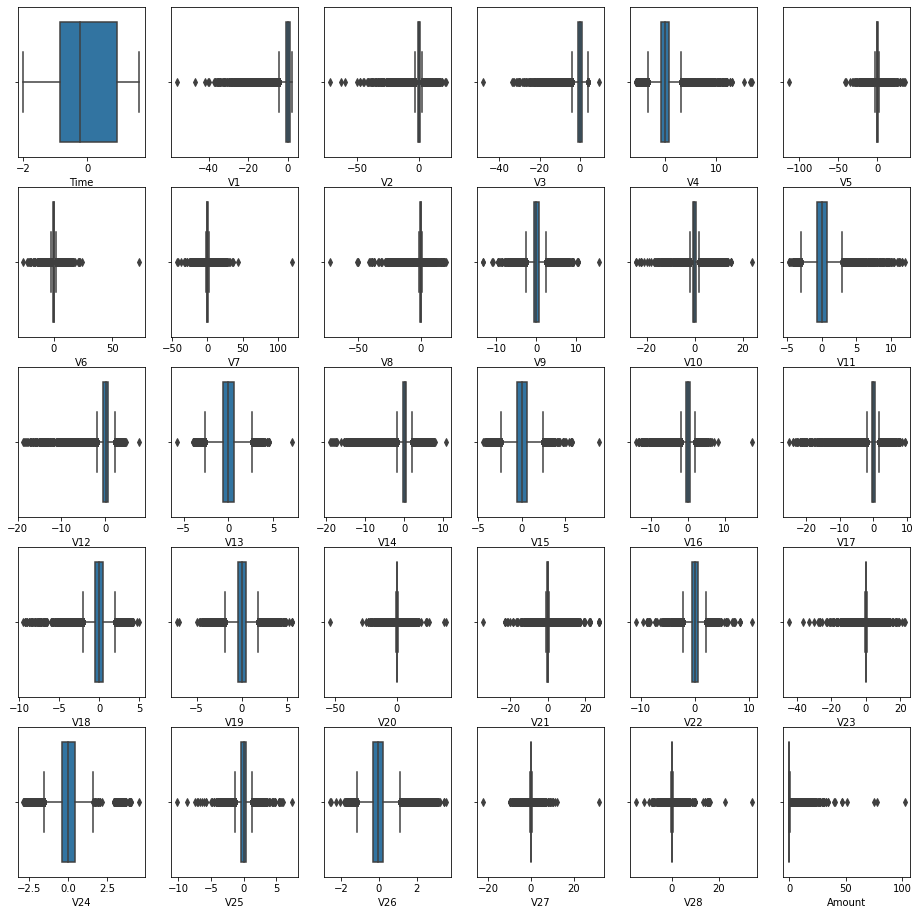

In [13]:
# ящики с усами для всех признаков
fig, ax = plt.subplots(5, 6)
fig.set_figheight(16)
fig.set_figwidth(16)
col = 0
for i in range(5):
    for j in range(6):
        sns.boxplot(x=X.columns[col], data=X, ax=ax[i, j])
        col += 1

Как видно по ящикам с усами, в данных находится множество выбросов. Далее избавимся от них.

In [14]:
# функция для удаления выбросов
def remove_outliers(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.25,0.75]).values
            IQR = percentiles[1] - percentiles[0]
            upper_limit = percentiles[1] + IQR*1.5
            lower_limit = percentiles[0] - IQR*1.5
            df[col][df[col] <= lower_limit] = percentiles[0]
            df[col][df[col] >= upper_limit] = percentiles[1]
        else:
            df[col]=df[col]

In [15]:
# убираем все выбросы за 2 итерации
for i in range(2):
    remove_outliers(X)

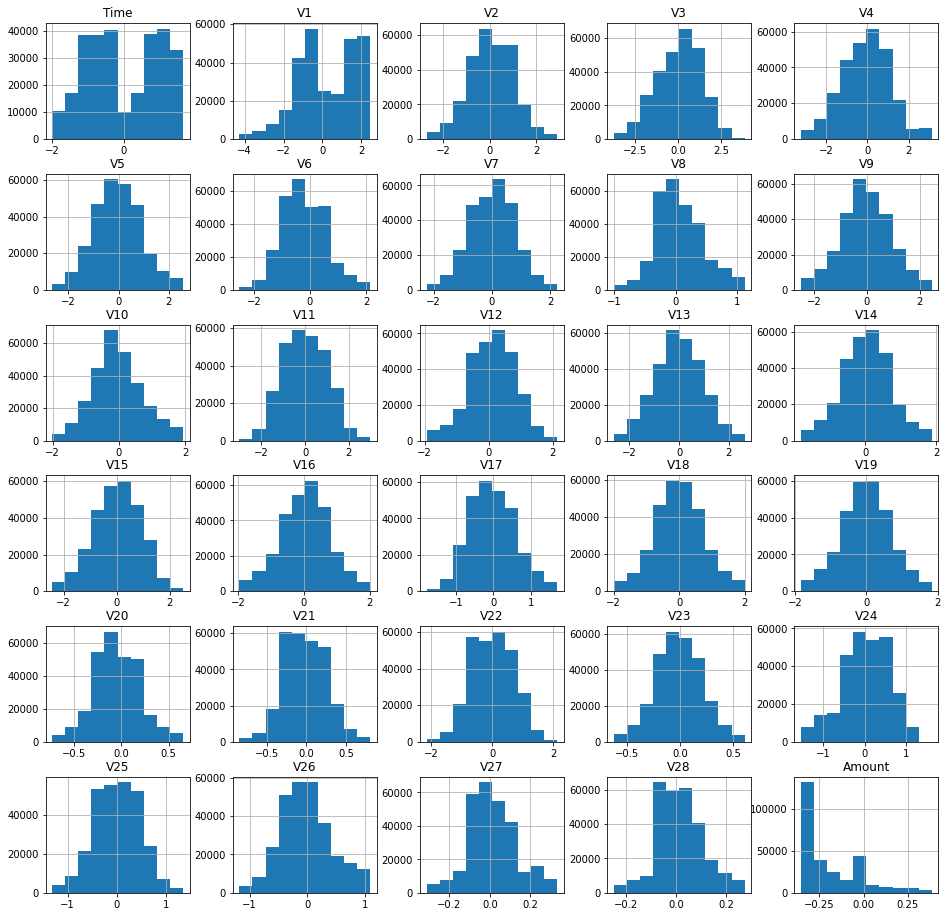

In [16]:
# графики гистограмм распределений всех признаков после удаления выбросов
fig = plt.figure(figsize=(16, 16))
ax = fig.gca()
X.hist(ax=ax)
plt.show()

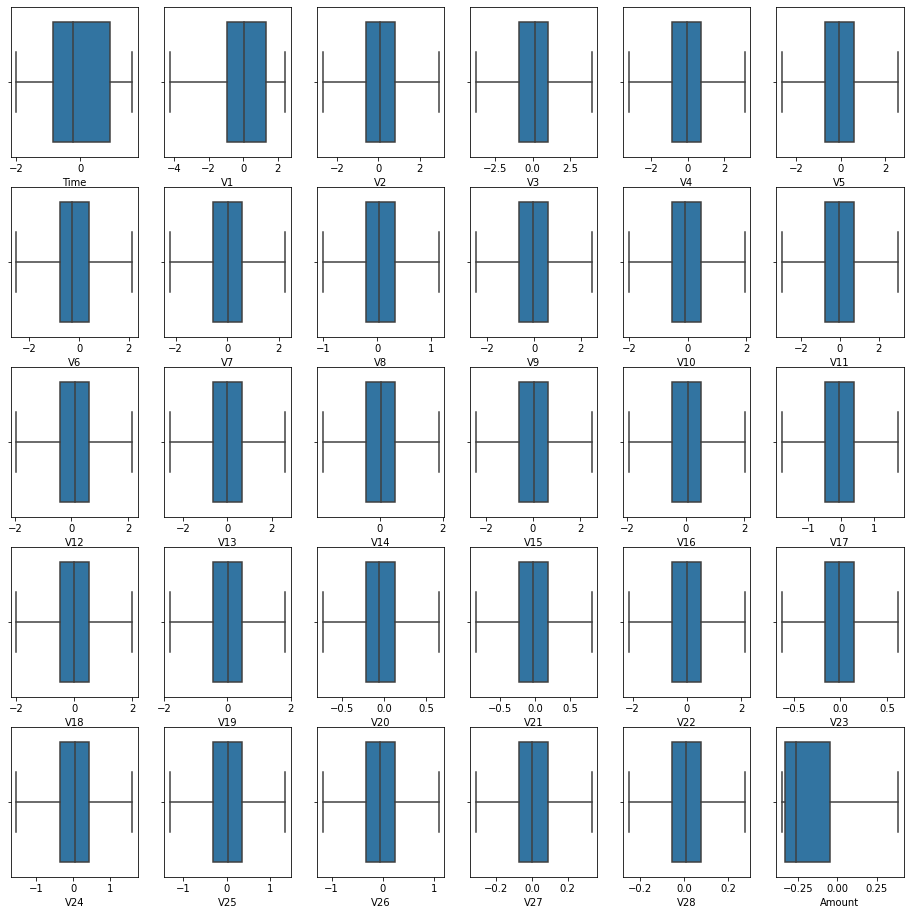

In [17]:
# ящики с усами для всех признаков после удаления выбросов
fig, ax = plt.subplots(5, 6)
fig.set_figheight(16)
fig.set_figwidth(16)
col = 0
for i in range(5):
    for j in range(6):
        sns.boxplot(x=X.columns[col], data=X, ax=ax[i, j])
        col += 1

На данном этапе все признаки масштабированы, а выбросы удалены. Далее посмотрим на тепловые карты корреляций Пирсона и Спирмена для признаков исходных данных (масштабированных, но с выбросами).

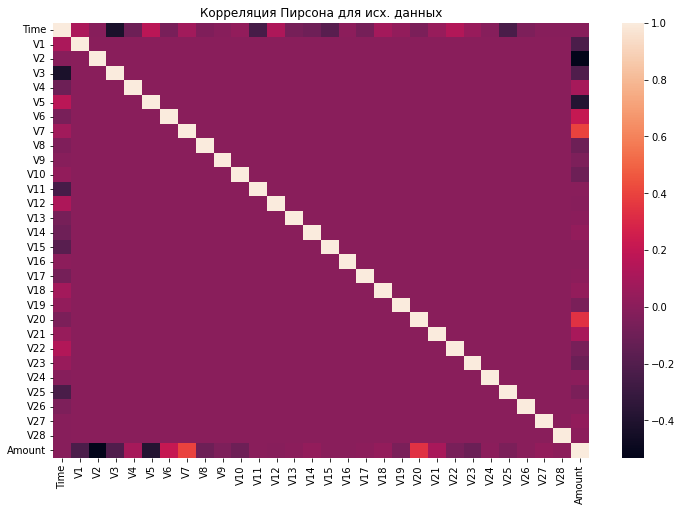

In [18]:
# тепловая карта корреляций Пирсона для исходных данных
corr_i1 = data.drop(['Class'], axis=1).corr(method='pearson')
plt.figure(figsize=(12, 8))
plt.title('Корреляция Пирсона для исх. данных')
sns.heatmap(corr_i1)
plt.show()

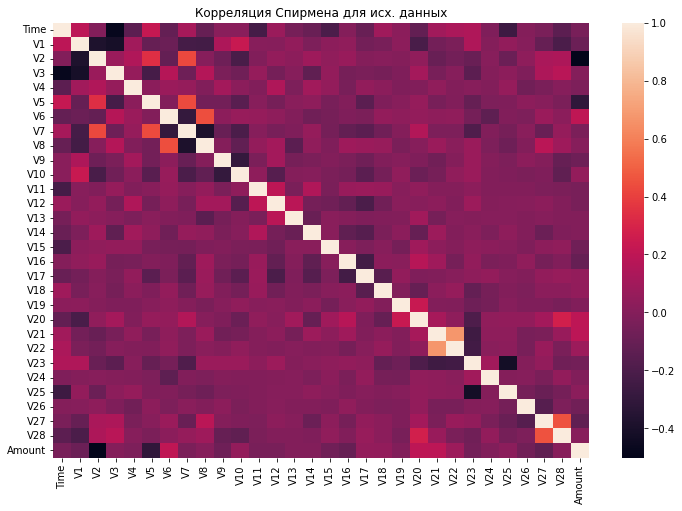

In [19]:
# тепловая карта корреляций Спирмена для исходных данных
corr_i2 = data.drop(['Class'], axis=1).corr(method='spearman')
plt.figure(figsize=(12, 8))
plt.title('Корреляция Спирмена для исх. данных')
sns.heatmap(corr_i2)
plt.show()

Как видно по картам, большинство признаков, кроме Time и Amount, не имеют линейных связей (так как 28 признаков - компоненты PCA). При этом, коэффициент корреляции Спирмена показывает, что некоторые признаки связаны друг с другом.

Сформируем сбалансированный набор из обработанных данных, в котором будет одинаковое количество элементов первого и второго классов.

In [20]:
shuffled = data.sample(frac=1, random_state=0) # перемешивание данных по строкам
fraud_idx = data[data['Class'] == 1].index # индексы мошеннических транзакций
valid_idx = data.loc[data['Class'] == 0][:492].index # индексы валидных транзакций
balanced_X = pd.concat([X[X.index.isin(fraud_idx)], X[X.index.isin(valid_idx)]]) # сбалансированный набор признаков
balanced_y = pd.concat([y[y.index.isin(fraud_idx)], y[y.index.isin(valid_idx)]]) # сбалансированный набор откликов
balanced_set = pd.concat([balanced_X, balanced_y], axis=1) # итоговый сбалансированный набор данных

In [21]:
balanced_set = balanced_set.sample(frac=1, random_state=0) # перемешивание по строкам

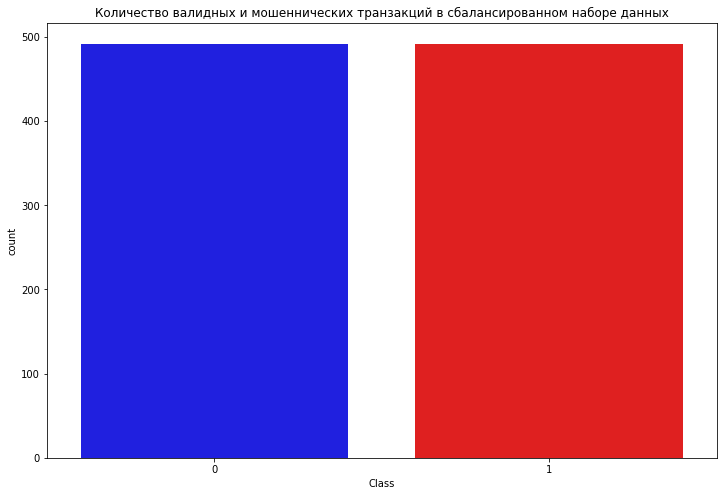

In [22]:
# столбчатая диаграмма количества объектов по классам в сбалансированном наборе данных
plt.figure(figsize=(12, 8))
sns.countplot('Class', data=balanced_set, palette=['blue', 'red'])
plt.title('Количество валидных и мошеннических транзакций в сбалансированном наборе данных')
plt.show()

---

## Построение моделей

1. Алгоритм k-NN заключается в нахождении расстояния от нового объекта до каждого объекта тренировочных данных и присвоении наиболее часто встречающегося класса новому объекту среди k ближайших объектов.

2. В основе логистической регрессии лежит логистическая функция (сигмоида).

3. XGBoost классификатор - это алгоритм бустинга над решающими деревьями, который последовательно обучает деревья, пытаясь уменьшить ошибку всего ансамбля.

### Данные без выбросов

In [23]:
# разделим обработанный несбалансированный набор данных на два: тренировочный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### K-Nearest Neighbors

In [24]:
knn = KNeighborsClassifier() # количество соседей: 5, метрика: Евклидово расстояние

In [25]:
knn.fit(X_train, y_train) # тренировка модели

KNeighborsClassifier()

In [26]:
y_pred = knn.predict(X_test) # предсказываем отклик для тестового набора признаков

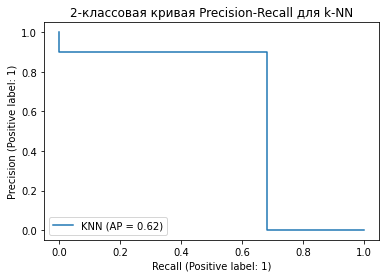

In [27]:
# AUPRC
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="KNN")
display.ax_.set_title("2-классовая кривая Precision-Recall для k-NN")
plt.show()

Average precision:

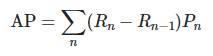

где Rn - значение Recall в n-ом пороге, Pn - значение Precision в n-ом пороге.

In [28]:
print(classification_report(y_test, y_pred)) # основные метрики классификации

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.90      0.68      0.78       120

    accuracy                           1.00     71202
   macro avg       0.95      0.84      0.89     71202
weighted avg       1.00      1.00      1.00     71202



#### Logistic Regression

In [29]:
log_reg = LogisticRegression() # пороговое значение: 0.5

In [30]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [31]:
y_pred_1 = log_reg.predict(X_test)

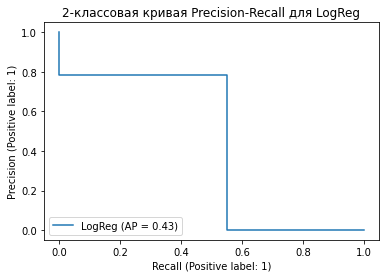

In [32]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_1, name="LogReg")
display.ax_.set_title("2-классовая кривая Precision-Recall для LogReg")
plt.show()

In [33]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.79      0.55      0.65       120

    accuracy                           1.00     71202
   macro avg       0.89      0.77      0.82     71202
weighted avg       1.00      1.00      1.00     71202



#### XGBClassifier

In [34]:
xgb = XGBClassifier()

In [35]:
xgb.fit(X_train, y_train)

XGBClassifier()

In [36]:
y_pred_2 = xgb.predict(X_test)

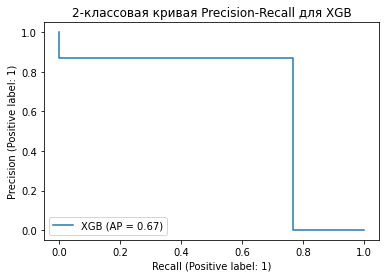

In [37]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_2, name="XGB")
display.ax_.set_title("2-классовая кривая Precision-Recall для XGB")
plt.show()

In [38]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.87      0.77      0.81       120

    accuracy                           1.00     71202
   macro avg       0.93      0.88      0.91     71202
weighted avg       1.00      1.00      1.00     71202



---

### Метрики на сбалансированных данных

In [39]:
balanced_X, balanced_y = balanced_set.drop(['Class'], axis=1), balanced_set[['Class']]

In [40]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_X, balanced_y, random_state=0)

#### K-Nearest Neighbors

In [41]:
knn = KNeighborsClassifier()

In [42]:
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [43]:
y_pred_balanced = knn.predict(X_test_balanced)

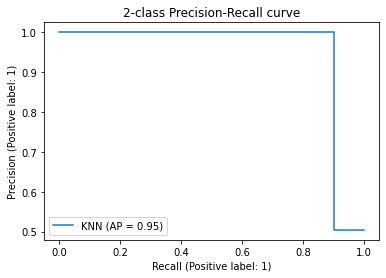

In [44]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced, name="KNN")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [45]:
print(classification_report(y_test_balanced, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       122
           1       1.00      0.90      0.95       124

    accuracy                           0.95       246
   macro avg       0.96      0.95      0.95       246
weighted avg       0.96      0.95      0.95       246



#### Logistic Regression

In [46]:
log_reg = LogisticRegression()

In [47]:
log_reg.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [48]:
y_pred_balanced_1 = log_reg.predict(X_test_balanced)

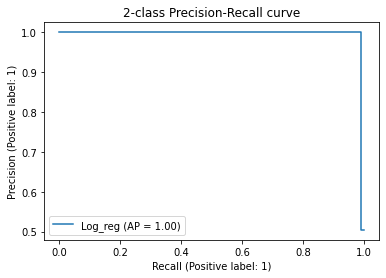

In [49]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced_1, name="Log_reg")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [50]:
print(classification_report(y_test_balanced, y_pred_balanced_1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       122
           1       1.00      0.99      1.00       124

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#### XGBClassifier

In [51]:
xgb = XGBClassifier()

In [52]:
xgb.fit(X_train_balanced, y_train_balanced)

XGBClassifier()

In [53]:
y_pred_balanced_2 = xgb.predict(X_test_balanced)

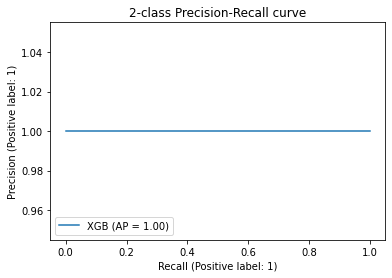

In [54]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced_2, name="XGB")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [55]:
print(classification_report(y_test_balanced, y_pred_balanced_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       124

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



---

## Данные с выбросами

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Class'], axis=1), y, random_state=0)

#### K-Nearest Neighbors

In [57]:
knn = KNeighborsClassifier()

In [58]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [59]:
y_pred = knn.predict(X_test)

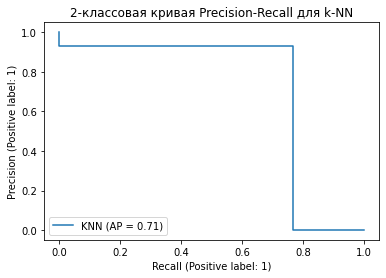

In [60]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="KNN")
display.ax_.set_title("2-классовая кривая Precision-Recall для k-NN")
plt.show()

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.93      0.77      0.84       120

    accuracy                           1.00     71202
   macro avg       0.96      0.88      0.92     71202
weighted avg       1.00      1.00      1.00     71202



#### Logistic Regression

In [62]:
log_reg = LogisticRegression()

In [63]:
log_reg.fit(X_train, y_train)

LogisticRegression()

In [64]:
y_pred_1 = log_reg.predict(X_test)

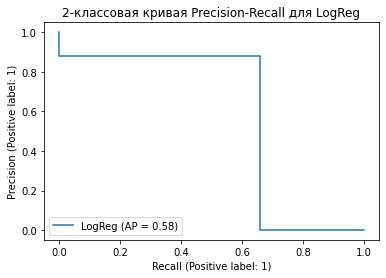

In [65]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_1, name="LogReg")
display.ax_.set_title("2-классовая кривая Precision-Recall для LogReg")
plt.show()

In [66]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.88      0.66      0.75       120

    accuracy                           1.00     71202
   macro avg       0.94      0.83      0.88     71202
weighted avg       1.00      1.00      1.00     71202



#### XGBClassifier

In [67]:
xgb = XGBClassifier()

In [68]:
xgb.fit(X_train, y_train)

XGBClassifier()

In [69]:
y_pred_2 = xgb.predict(X_test)

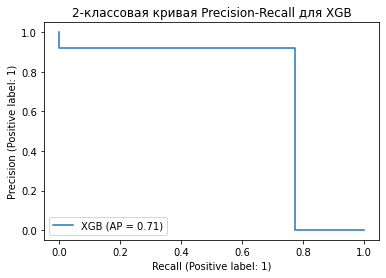

In [70]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred_2, name="XGB")
display.ax_.set_title("2-классовая кривая Precision-Recall для XGB")
plt.show()

In [71]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71082
           1       0.92      0.78      0.84       120

    accuracy                           1.00     71202
   macro avg       0.96      0.89      0.92     71202
weighted avg       1.00      1.00      1.00     71202



---

### Метрики на сбалансированных данных

In [72]:
balanced_X, balanced_y = balanced_set.drop(['Class'], axis=1), balanced_set[['Class']]

In [73]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(balanced_X, balanced_y, random_state=0)

#### K-Nearest Neighbors

In [74]:
knn = KNeighborsClassifier()

In [75]:
knn.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier()

In [76]:
y_pred_balanced = knn.predict(X_test_balanced)

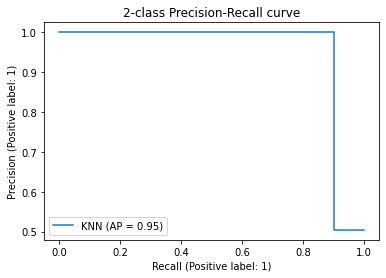

In [77]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced, name="KNN")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [78]:
print(classification_report(y_test_balanced, y_pred_balanced))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       122
           1       1.00      0.90      0.95       124

    accuracy                           0.95       246
   macro avg       0.96      0.95      0.95       246
weighted avg       0.96      0.95      0.95       246



#### Logistic Regression

In [79]:
log_reg = LogisticRegression()

In [80]:
log_reg.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [81]:
y_pred_balanced_1 = log_reg.predict(X_test_balanced)

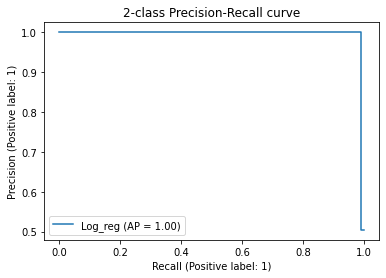

In [82]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced_1, name="Log_reg")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [83]:
print(classification_report(y_test_balanced, y_pred_balanced_1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       122
           1       1.00      0.99      1.00       124

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#### XGBClassifier

In [84]:
xgb = XGBClassifier()

In [85]:
xgb.fit(X_train_balanced, y_train_balanced)

XGBClassifier()

In [86]:
y_pred_balanced_2 = xgb.predict(X_test_balanced)

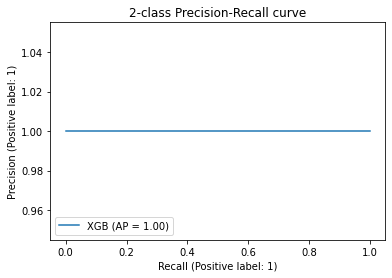

In [87]:
display = PrecisionRecallDisplay.from_predictions(y_test_balanced, y_pred_balanced_2, name="XGB")
display.ax_.set_title("2-class Precision-Recall curve")
plt.show()

In [88]:
print(classification_report(y_test_balanced, y_pred_balanced_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       122
           1       1.00      1.00      1.00       124

    accuracy                           1.00       246
   macro avg       1.00      1.00      1.00       246
weighted avg       1.00      1.00      1.00       246



#### Результаты для данных без выбросов

In [89]:
table = [['Модель', 'AP_несбалансировано', 'AP_сбалансировано'],
         ['KNN',0.62, 0.95],
         ['LogReg',0.43, 1.0],
         ['XGB',0.67, 1.0]]

In [90]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════════════╤═════════════════════╕
│ Модель   │   AP_несбалансировано │   AP_сбалансировано │
╞══════════╪═══════════════════════╪═════════════════════╡
│ KNN      │                  0.62 │                0.95 │
├──────────┼───────────────────────┼─────────────────────┤
│ LogReg   │                  0.43 │                1    │
├──────────┼───────────────────────┼─────────────────────┤
│ XGB      │                  0.67 │                1    │
╘══════════╧═══════════════════════╧═════════════════════╛


#### Результаты для данных с выбросами

In [91]:
table = [['Модель', 'AP_несбалансировано', 'AP_сбалансировано'],
         ['KNN',0.71, 0.95],
         ['LogReg',0.58, 1.0],
         ['XGB',0.71, 1.0]]

In [92]:
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════════════╤═════════════════════╕
│ Модель   │   AP_несбалансировано │   AP_сбалансировано │
╞══════════╪═══════════════════════╪═════════════════════╡
│ KNN      │                  0.71 │                0.95 │
├──────────┼───────────────────────┼─────────────────────┤
│ LogReg   │                  0.58 │                1    │
├──────────┼───────────────────────┼─────────────────────┤
│ XGB      │                  0.71 │                1    │
╘══════════╧═══════════════════════╧═════════════════════╛


---

## Вывод

Таким образом, в случае несбалансированных данных, все модели показали себя лучше на данных с выбросами. Качество предсказания моделей на сбалансированных данных превышает качество предсказания на несбалансированных. В совокупности экспериментов лучше всего с задачей справился XGB классификатор.